# Анализ научных статей о COVID-19

В этом задании мы продолжим тему пандемии COVID и сосредоточимся на обработке научных статей по данной теме. Существует [набор данных CORD-19](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge), содержащий более 7000 (на момент написания) статей о COVID. Этот набор данных включает метаданные и аннотации (а для примерно половины статей доступен полный текст).

Полный пример анализа этого набора данных с использованием когнитивного сервиса [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) описан [в этом блоге](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Мы обсудим упрощённую версию этого анализа.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Получение данных

Сначала нам нужно получить метаданные для статей CORD, с которыми мы будем работать.

**NOTE**: Мы не предоставляем копию набора данных в этом репозитории. Вам сначала нужно будет скачать файл [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) из [этого набора данных на Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Для этого может потребоваться регистрация на Kaggle. Вы также можете скачать набор данных без регистрации [отсюда](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), но он будет включать все полные тексты в дополнение к файлу метаданных.

Мы попробуем получить данные напрямую из онлайн-источника, однако, если это не удастся, вам нужно будет скачать данные, как описано выше. Также имеет смысл загрузить данные, если вы планируете работать с ними дальше, чтобы сэкономить время ожидания.

> **NOTE**: Набор данных довольно большой, около 1 Гб, и выполнение следующей строки кода может занять много времени! (~5 минут)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Мы теперь преобразуем столбец с датой публикации в `datetime` и построим гистограмму, чтобы увидеть диапазон дат публикации.


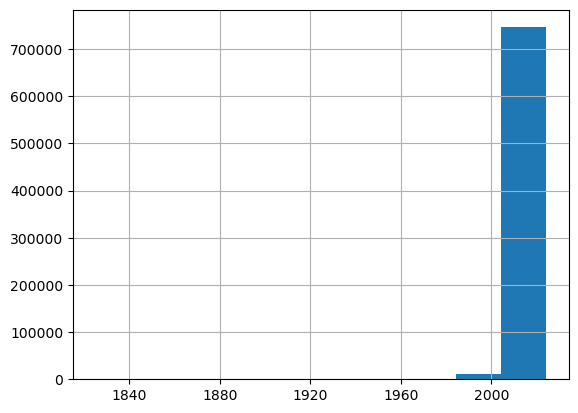

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Извлечение структурированных данных

Давайте посмотрим, какую информацию можно легко извлечь из аннотаций. Одним из интересных аспектов может быть изучение существующих стратегий лечения и их эволюции со временем. Для начала мы можем вручную составить список возможных препаратов, используемых для лечения COVID, а также список диагнозов. Затем мы просматриваем их и ищем соответствующие термины в аннотациях статей.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Мы добавили несколько столбцов в наш датафрейм, которые содержат количество упоминаний конкретного лекарства/диагноза в аннотации.

> **Обратите внимание**, что мы добавляем пробел в начале слова при поиске подстроки. Если этого не сделать, можно получить некорректные результаты, так как *хлорохин* также будет найден внутри подстроки *гидроксихлорохин*. Кроме того, мы принудительно преобразуем столбец аннотаций в `str`, чтобы избежать ошибки — попробуйте убрать `str` и посмотрите, что произойдет.

Чтобы упростить работу с данными, мы можем извлечь подрамку, содержащую только количество упоминаний лекарств, и вычислить накопленное количество вхождений. Это позволяет определить самое популярное лекарство:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

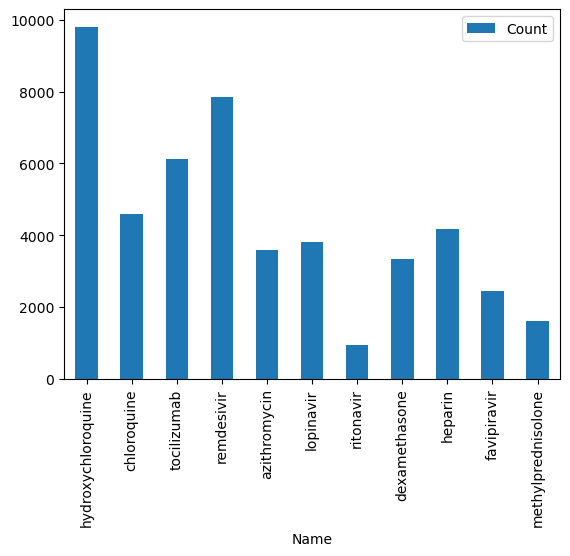

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Поиск тенденций в стратегии лечения

В приведенном выше примере мы использовали функцию `sum` для подсчета всех значений, но мы также можем делать то же самое на ежемесячной основе:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

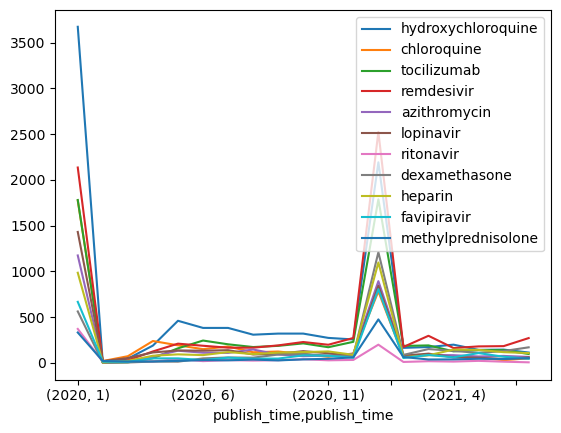

In [152]:
dfmt.plot()
plt.show()

Интересное наблюдение: у нас есть огромные всплески в двух местах — январь 2020 года и январь 2021 года. Это связано с тем, что некоторые статьи не имеют четко указанной даты публикации, и они обозначены как январь соответствующего года.

Чтобы лучше понять данные, давайте визуализируем только несколько лекарств. Мы также "уберем" данные за январь и заменим их некоторым средним значением, чтобы получить более красивый график:


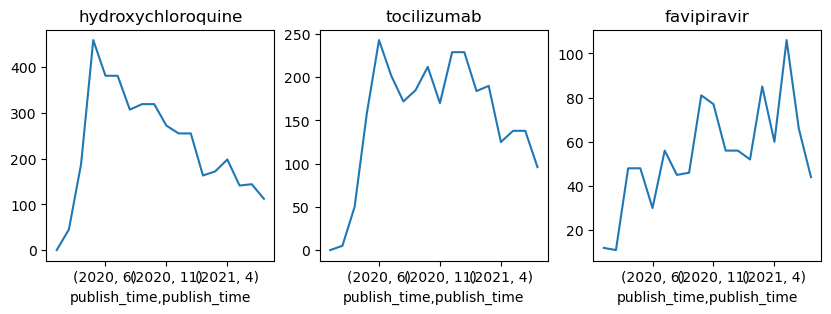

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

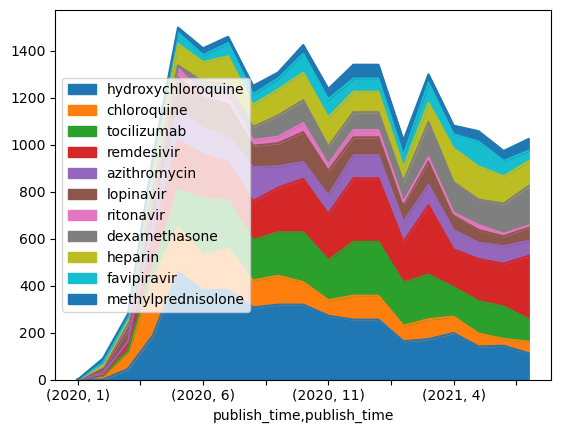

In [154]:
dfmt.plot.area()
plt.show()

Более того, мы можем вычислить относительную популярность в процентах:


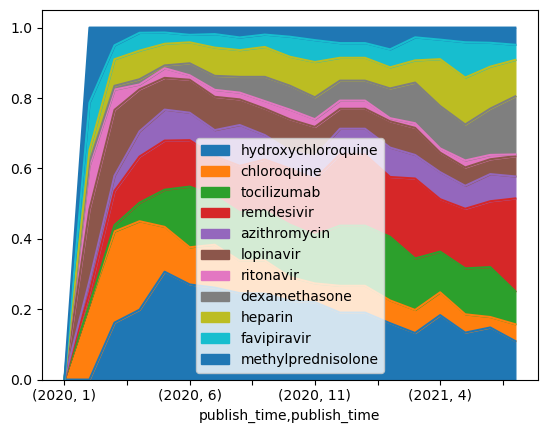

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Соответствие между лекарствами и диагнозами

Одним из самых интересных отношений, которые мы можем исследовать, является то, как различные диагнозы лечатся различными лекарствами. Чтобы визуализировать это, нам нужно вычислить **карту частоты совместного упоминания**, которая покажет, сколько раз два термина упоминаются в одном и том же документе.

Такая карта по сути представляет собой двумерную матрицу, которую лучше всего представить в виде **numpy массива**. Мы будем вычислять эту карту, проходя через все аннотации и отмечая сущности, которые там встречаются:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Один из способов визуализировать эту матрицу — нарисовать **тепловую карту**:


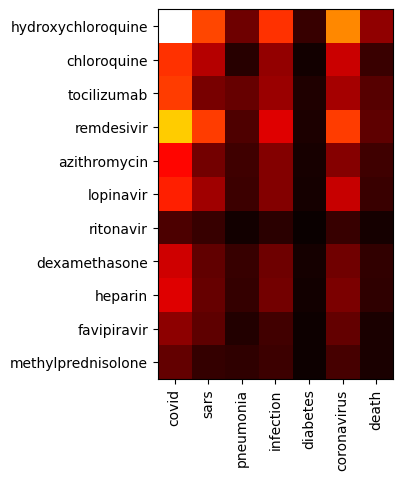

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Однако еще лучше визуализировать данные можно с помощью так называемой диаграммы **Санкея**! Библиотека `matplotlib` не поддерживает этот тип диаграмм из коробки, поэтому нам придется использовать [Plotly](https://plotly.com/python/), как описано [в этом руководстве](https://plotly.com/python/sankey-diagram/).

Чтобы построить диаграмму Санкея с помощью Plotly, нам нужно создать следующие списки:
* Список `all_nodes` всех узлов графа, который будет включать как лекарства, так и диагнозы
* Списки индексов источников и целей - эти списки покажут, какие узлы находятся слева, а какие справа на диаграмме
* Список всех связей, каждая из которых состоит из:
   - Индекса источника в массиве `all_nodes`
   - Индекса цели
   - Значения, указывающего силу связи. Это значение берется из нашей матрицы совместной встречаемости.
   - Опционально цвета связи. Мы добавим возможность выделять некоторые термины для большей наглядности

Общий код для построения диаграммы Санкея оформлен в виде отдельной функции `sankey`, которая принимает два списка (категории источников и целей) и матрицу совместной встречаемости. Она также позволяет задать пороговое значение и исключить все связи, которые слабее этого порога, — это делает диаграмму немного менее сложной.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Заключение

Вы увидели, что можно использовать довольно простые методы для извлечения информации из неструктурированных источников данных, таких как текст. В этом примере мы использовали существующий список медикаментов, но гораздо более мощным подходом было бы использование методов обработки естественного языка (NLP) для извлечения сущностей из текста. В [этом блоге](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) мы описываем, как использовать облачные сервисы для извлечения сущностей. Другим вариантом может быть использование библиотек NLP для Python, таких как [NLTK](https://www.nltk.org/) - подход к извлечению информации из текста с помощью NLTK описан [здесь](https://www.nltk.org/book/ch07.html).


## Задача

Продолжайте исследовать данные из статей о COVID в следующих направлениях:

1. Постройте матрицу совместной встречаемости различных медикаментов и определите, какие препараты часто упоминаются вместе (например, в одном абстракте). Вы можете модифицировать код для построения матрицы совместной встречаемости медикаментов и диагнозов.
1. Визуализируйте эту матрицу с помощью тепловой карты.
1. В качестве дополнительной задачи вы можете попробовать визуализировать совместную встречаемость медикаментов с помощью [хордовой диаграммы](https://en.wikipedia.org/wiki/Chord_diagram). [Эта библиотека](https://pypi.org/project/chord/) может помочь вам нарисовать хордовую диаграмму.
1. В качестве еще одной дополнительной задачи попробуйте извлечь дозировки различных медикаментов (например, **400мг** в *принимайте 400мг хлорохина ежедневно*) с использованием регулярных выражений и создайте dataframe, который показывает различные дозировки для разных медикаментов. **Примечание**: учитывайте числовые значения, которые находятся в непосредственной текстовой близости от названия лекарства.



---

**Отказ от ответственности**:  
Этот документ был переведен с помощью сервиса автоматического перевода [Co-op Translator](https://github.com/Azure/co-op-translator). Хотя мы стремимся к точности, пожалуйста, имейте в виду, что автоматические переводы могут содержать ошибки или неточности. Оригинальный документ на его исходном языке следует считать авторитетным источником. Для получения критически важной информации рекомендуется профессиональный перевод человеком. Мы не несем ответственности за любые недоразумения или неправильные толкования, возникшие в результате использования данного перевода.
